# Advanced Computer Vision Topics

## Session4: Object Detection (3 hours)

In [1]:
import os
import warnings
import cv2

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.applications.mobilenet import (
    MobileNet, preprocess_input,
)
from tensorflow.keras.preprocessing.image import (
    img_to_array, load_img,
)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Reshape
from tensorflow.keras.callbacks import EarlyStopping

from plot_layers import (
    plot_layer_outputs, imshow, apply_patch,
    IoU_metric,
)
warnings.simplefilter("ignore")
%matplotlib inline

In [2]:
LOCAL_DATA_PATH = os.path.join(os.path.abspath(''), 'data', 'images', 'localization', 'pets')
# Ref: https://www.robots.ox.ac.uk/~vgg/data/pets/

In [3]:
TARGET_SIZE = (128, 128)
# image name and the object bounding box informations
TRAIN_DATA_DF = pd.read_csv(os.path.join(LOCAL_DATA_PATH, 'train.csv'), header=None)
TEST_DATA_DF = pd.read_csv(os.path.join(LOCAL_DATA_PATH, 'test.csv'), header=None)

In [4]:
HEADER = ['ImagePath', 'Height', 'Width', 'X0', 'Y0', 'X1', 'Y1', 'Breed', 'BreedCategory']
TRAIN_DATA_DF.columns = HEADER
TEST_DATA_DF.columns = HEADER

In [5]:
TRAIN_DATA_DF.head()

,ImagePath,Height,Width,X0,Y0,X1,Y1,Breed,BreedCategory
0,images/Abyssinian_1.jpg,400,600,173,72,265,158,abyssinian,0
1,images/Abyssinian_10.jpg,500,375,72,105,288,291,abyssinian,0
2,images/Abyssinian_100.jpg,500,394,151,71,335,267,abyssinian,0
3,images/Abyssinian_101.jpg,313,450,54,36,319,235,abyssinian,0
4,images/Abyssinian_102.jpg,465,500,23,27,325,320,abyssinian,0


In [6]:
TEST_DATA_DF.head()

,ImagePath,Height,Width,X0,Y0,X1,Y1,Breed,BreedCategory
0,images/Abyssinian_118.jpg,500,333,1,34,257,303,abyssinian,0
1,images/Abyssinian_124.jpg,500,333,88,94,207,195,abyssinian,0
2,images/Abyssinian_131.jpg,320,311,17,25,206,180,abyssinian,0
3,images/Abyssinian_14.jpg,500,335,164,71,252,163,abyssinian,0
4,images/Abyssinian_15.jpg,422,477,16,16,431,357,abyssinian,0


In [7]:
def compute_y(df_inp):
    global TARGET_SIZE
    df_out = pd.DataFrame()
    # compute the y data for the target size
    df_out['X0'] = (df_inp['X0'] /  df_inp['Width']) * TARGET_SIZE[0]
    df_out['Y0'] = (df_inp['Y0'] /  df_inp['Height']) * TARGET_SIZE[1]

    df_out['Width'] = ((df_inp['X1'] - df_inp['X0']) / df_inp['Width']) * TARGET_SIZE[0]
    df_out['Height'] = ((df_inp['Y1'] - df_inp['Y0']) / df_inp['Height']) * TARGET_SIZE[1]

    return df_out

In [8]:
# # compute the y train data for the target size
# Y_TRAIN_DF['X0'] = (TRAIN_DATA_DF['X0'] /  TRAIN_DATA_DF['Width']) * TARGET_SIZE[0]
# Y_TRAIN_DF['Y0'] = (TRAIN_DATA_DF['X0'] /  TRAIN_DATA_DF['Height']) * TARGET_SIZE[1]

# Y_TRAIN_DF['Width'] = ((TRAIN_DATA_DF['X1'] - TRAIN_DATA_DF['X0']) / TRAIN_DATA_DF['Width']) * TARGET_SIZE[0]
# Y_TRAIN_DF['Height'] = ((TRAIN_DATA_DF['Y1'] - TRAIN_DATA_DF['Y0']) / TRAIN_DATA_DF['Height']) * TARGET_SIZE[1]
Y_TRAIN_DF = compute_y(TRAIN_DATA_DF)
Y_TRAIN_DF.head()

,X0,Y0,Width,Height
0,36.906667,23.040000,19.626667,27.520000
1,24.576000,26.880000,73.728000,47.616000
2,49.055838,18.176000,59.776650,50.176000
3,15.360000,14.722045,75.377778,81.380192
4,5.888000,7.432258,77.312000,80.653763


In [9]:
Y_TEST_DF = compute_y(TEST_DATA_DF)
Y_TEST_DF.head()

,X0,Y0,Width,Height
0,0.384384,8.704000,98.402402,68.86400
1,33.825826,24.064000,45.741742,25.85600
2,6.996785,10.000000,77.787781,62.00000
3,62.662687,18.176000,33.623881,23.55200
4,4.293501,4.853081,111.362683,103.43128


In [10]:
y_train = Y_TRAIN_DF.to_numpy()
y_test = Y_TEST_DF.to_numpy()

In [11]:
y_train

array([[36.90666667, 23.04      , 19.62666667, 27.52      ],
       [24.576     , 26.88      , 73.728     , 47.616     ],
       [49.05583756, 18.176     , 59.77664975, 50.176     ],
       ...,
       [24.064     , 13.79640719, 72.704     , 86.99401198],
       [70.144     , 32.19161677, 32.768     , 47.13772455],
       [24.591133  , 15.872     , 71.56650246, 49.664     ]])

In [12]:
y_test

array([[ 0.38438438,  8.704     , 98.4024024 , 68.864     ],
       [33.82582583, 24.064     , 45.74174174, 25.856     ],
       [ 6.99678457, 10.        , 77.78778135, 62.        ],
       ...,
       [52.48      , 36.18133333, 28.928     , 45.056     ],
       [24.832     ,  6.03141361, 49.408     , 76.06282723],
       [11.776     , 19.21921922, 67.84      , 88.02402402]])

In [13]:
# Load x_train and x_test
x_train = TRAIN_DATA_DF['ImagePath'].apply(lambda x: os.path.join(LOCAL_DATA_PATH, *x.split('/'))).to_numpy()
x_test = TEST_DATA_DF['ImagePath'].apply(lambda x: os.path.join(LOCAL_DATA_PATH, *x.split('/'))).to_numpy()

In [14]:
x_train[:5]

array(['/Users/midhuncnair/workspace/training/DeepLearningWithMidhun/DSATM/data/images/localization/pets/images/Abyssinian_1.jpg',
       '/Users/midhuncnair/workspace/training/DeepLearningWithMidhun/DSATM/data/images/localization/pets/images/Abyssinian_10.jpg',
       '/Users/midhuncnair/workspace/training/DeepLearningWithMidhun/DSATM/data/images/localization/pets/images/Abyssinian_100.jpg',
       '/Users/midhuncnair/workspace/training/DeepLearningWithMidhun/DSATM/data/images/localization/pets/images/Abyssinian_101.jpg',
       '/Users/midhuncnair/workspace/training/DeepLearningWithMidhun/DSATM/data/images/localization/pets/images/Abyssinian_102.jpg'],
      dtype=object)

In [15]:
x_test[:5]

array(['/Users/midhuncnair/workspace/training/DeepLearningWithMidhun/DSATM/data/images/localization/pets/images/Abyssinian_118.jpg',
       '/Users/midhuncnair/workspace/training/DeepLearningWithMidhun/DSATM/data/images/localization/pets/images/Abyssinian_124.jpg',
       '/Users/midhuncnair/workspace/training/DeepLearningWithMidhun/DSATM/data/images/localization/pets/images/Abyssinian_131.jpg',
       '/Users/midhuncnair/workspace/training/DeepLearningWithMidhun/DSATM/data/images/localization/pets/images/Abyssinian_14.jpg',
       '/Users/midhuncnair/workspace/training/DeepLearningWithMidhun/DSATM/data/images/localization/pets/images/Abyssinian_15.jpg'],
      dtype=object)

In [16]:
def has_files(paths):
    count = 0
    for path in paths:
        if os.path.exists(path):
            continue
        count += 1
        
    print(f"{count}/{len(paths)} missing")
has_files(x_train)
has_files(x_test)

0/3006 missing
0/680 missing


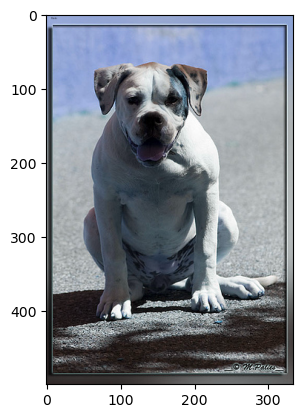

In [17]:
SAMPLE_LOCATION = 100
path = x_train[SAMPLE_LOCATION]
img = cv2.imread(x_train[SAMPLE_LOCATION])
imshow(img)

In [18]:
bb_x0 = TRAIN_DATA_DF['X0'][SAMPLE_LOCATION]
bb_y0 = TRAIN_DATA_DF['Y0'][SAMPLE_LOCATION]
bb_x1 = TRAIN_DATA_DF['X1'][SAMPLE_LOCATION]
bb_y1 = TRAIN_DATA_DF['Y1'][SAMPLE_LOCATION]

In [19]:
bb_x0, bb_y0, bb_x1, bb_y1

(64, 64, 217, 206)

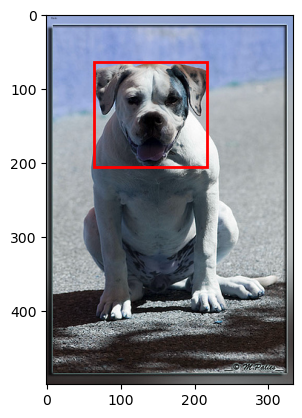

In [20]:
apply_patch(img, bb_x0, bb_y0, bb_x1, bb_y1)

In [21]:
def preprocess_images_for_model(paths):
    out = []
    for path in paths:
        img = load_img(path, target_size=TARGET_SIZE)
        img_arr = img_to_array(img)
        out.append(preprocess_input(img_arr))
        
    return np.array(out)

In [22]:
x_train = preprocess_images_for_model(x_train)
x_test = preprocess_images_for_model(x_test)

In [23]:
x_train.shape, y_train.shape

((3006, 128, 128, 3), (3006, 4))

In [24]:
x_test.shape, y_test.shape

((680, 128, 128, 3), (680, 4))

In [25]:
ALPHA = 1.0 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0).

def create_transfer_model_from_mobilenet(alpha, is_trainable=False):
    global TARGET_SIZE
    model = MobileNet(
        input_shape=(*TARGET_SIZE, 3), 
        include_top=False,  # Do not include classification/top layer
        alpha=alpha
    )


    for layer in model.layers:
        layer.trainable = is_trainable # freeze/unfreeze the pretrained layers.
    
    previous_layer = model.layers[-1]

    custom_layer1 = Conv2D(4, kernel_size=4)(previous_layer.output)
    output_layer = Reshape((4,))(custom_layer1)  # output size is 4.

    return Model(inputs=model.input, outputs=output_layer)


In [26]:
model = create_transfer_model_from_mobilenet(alpha=ALPHA, is_trainable=False)

2024-02-14 07:33:46.116237: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-14 07:33:46.116355: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2 Max


In [27]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32)       128       
 ation)                                                      

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 8, 8, 512)        2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 8, 8, 512)         0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 8, 8, 512)        4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 8, 8, 512)        2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 8, 8, 512)         0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 8, 8, 512)         262144    
                                                                 
 conv_pw_9

In [28]:
model.compile(
    loss="mean_squared_error", # Regression loss is MSE
    optimizer="adam",
    metrics=['accuracy', IoU_metric]
)

In [29]:
callback = EarlyStopping(monitor='accuracy', patience=5, min_delta=0.01)

In [30]:
# Fit the model
model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=5, batch_size=32,
    callbacks=[callback]
)

Epoch 1/5


2024-02-14 07:33:46.689483: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-02-14 07:33:47.041602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - ETA: 0s - loss: 284.2299 - accuracy: 0.6055 - IoU_metric: 0.4969

2024-02-14 07:33:54.890058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 10s 100ms/step - loss: 284.2299 - accuracy: 0.6055 - IoU_metric: 0.4969 - val_loss: 112.7708 - val_accuracy: 0.7368 - val_IoU_metric: 0.6189
Epoch 2/5
94/94 [==============================] - 9s 93ms/step - loss: 80.6678 - accuracy: 0.7891 - IoU_metric: 0.6634 - val_loss: 92.7416 - val_accuracy: 0.7794 - val_IoU_metric: 0.6434
Epoch 3/5
94/94 [==============================] - 9s 93ms/step - loss: 54.4289 - accuracy: 0.8263 - IoU_metric: 0.7118 - val_loss: 91.1539 - val_accuracy: 0.7794 - val_IoU_metric: 0.6454
Epoch 4/5
94/94 [==============================] - 9s 94ms/step - loss: 40.2725 - accuracy: 0.8603 - IoU_metric: 0.7447 - val_loss: 88.6146 - val_accuracy: 0.7868 - val_IoU_metric: 0.6499
Epoch 5/5
94/94 [==============================] - 9s 94ms/step - loss: 31.1377 - accuracy: 0.8772 - IoU_metric: 0.7705 - val_loss: 90.3003 - val_accuracy: 0.7882 - val_IoU_metric: 0.6456


In [31]:
model.evaluate(x_test, y_test)

22/22 [==============================] - 2s 73ms/step - loss: 90.3003 - accuracy: 0.7882 - IoU_metric: 0.6456


[90.30025482177734, 0.7882353067398071, 0.6455636024475098]

In [32]:
def test_model(model):
    images = {
        'samoyed_174.jpg',
        'shiba_inu_163.jpg',
        'Abyssinian_14.jpg',
    }
    for image in images:
        image_file = os.path.join(LOCAL_DATA_PATH, 'images', image)
        img = load_img(image_file, target_size=TARGET_SIZE)
        img_array = img_to_array(img)
        preds = model.predict(np.expand_dims(img_array, axis=0))[0]
        img = cv2.imread(image_file)
        height, width, _ = img.shape

        x0 = int(preds[0] * width / TARGET_SIZE[0])
        y0 = int(preds[1] * height / TARGET_SIZE[1])

        x1 = int((preds[0] + preds[2]) * width / TARGET_SIZE[0])
        y1 = int((preds[1] + preds[3]) * height / TARGET_SIZE[1])
        apply_patch(img, x0, y0, x1, y1)

2024-02-14 07:34:33.722936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 291ms/step


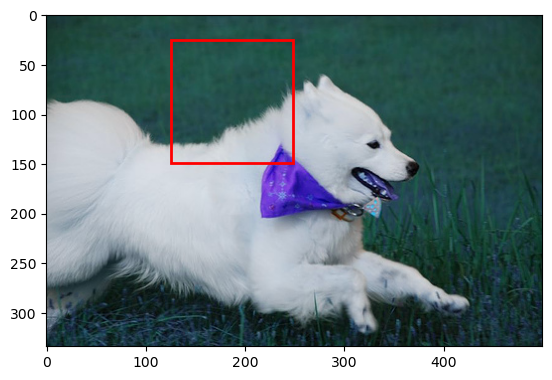

1/1 [==============================] - 0s 14ms/step


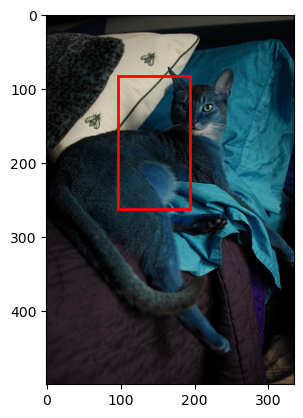

1/1 [==============================] - 0s 13ms/step


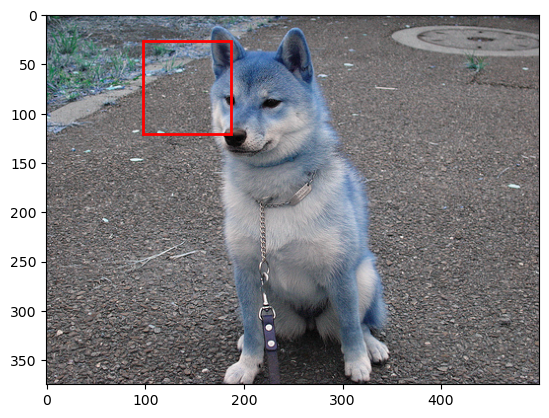

In [33]:
test_model(model)